In [52]:
import pandas as pd
import numpy as np
import time

from itertools import combinations
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt



In [3]:
import seaborn as sns

In [4]:
import node2vec
from gensim.models import Word2Vec

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
''' load in data '''
games = pd.read_csv("../2023/data/games.csv")
players = pd.read_csv("../2023/data/players.csv")
plays = pd.read_csv("../2023/data/plays.csv")

ngs_df = pd.read_csv("../2023/data/week1.csv")
print(f"dataframe shape = {ngs_df.shape}")
for i in range(2,9):
    ngs_df = pd.concat([ngs_df,pd.read_csv(f"../2023/data/week{i}.csv") ])

dataframe shape = (1118122, 16)


In [7]:
embed_3_dim = pd.read_csv("2022_3_dim_full_player_embed_df.csv", index_col=0)
embed_9_dim = pd.read_csv("2022_9_dim_full_player_embed_df.csv", index_col=0)
embed_32_dim = pd.read_csv("2022_full_player_embed_df.csv", index_col=0)

In [73]:
embed_32_dim.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,nflId,position
displayName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
David Long,-0.243633,-1.308358,0.931337,1.118743,-0.412155,-1.061731,1.795956,0.832513,-0.748043,-0.194943,0.550681,-0.257446,0.292334,0.216967,-1.185289,-0.569765,-0.233435,1.363359,-0.375071,0.262129,0.473137,1.567027,2.262220,-1.115465,0.858981,-0.358569,-0.483874,0.889076,-0.186108,-0.864384,-1.078716,-0.465904,47862.0,CB
Gabe Davis,-0.919333,-3.708827,2.778434,2.686772,-0.806195,-2.849146,4.784183,1.752988,-1.802447,-0.241791,1.490319,-0.820288,0.764951,0.551439,-2.701238,-1.590109,-0.842738,3.175034,-0.596924,0.477496,1.185441,4.047108,6.126431,-2.909370,2.148940,-0.702132,-1.584896,2.274493,-0.531693,-2.783012,-3.001867,-1.341409,52536.0,WR
Nick Scott,-2.287931,-3.982921,3.226217,2.532299,-0.875158,-2.085616,5.495210,1.663377,-0.380239,-0.342056,1.842230,-0.227996,1.640130,-0.332317,-2.073540,-2.966493,-2.087404,3.249974,1.295730,1.613875,1.052569,4.650994,5.972294,-3.485752,1.469225,0.014704,-1.247068,1.030909,0.752968,-2.924782,-2.551167,-0.690713,48026.0,SS
Troy Hill,-0.638467,-1.512752,1.193222,0.985631,-0.287466,-0.993047,2.113661,0.616814,-0.374365,-0.036549,0.673225,-0.136352,0.493341,0.014431,-1.017876,-0.880506,-0.623563,1.354836,0.174403,0.485366,0.490503,1.753379,2.393044,-1.347015,0.708756,-0.238696,-0.527500,0.661850,0.134026,-1.062740,-1.173929,-0.354251,42816.0,CB
Isaiah McKenzie,-0.866931,-1.942861,1.549403,1.232511,-0.341335,-1.190664,2.518738,0.737017,-0.496450,-0.042837,0.903952,-0.271413,0.537997,0.140027,-0.945903,-1.070537,-0.806934,1.345081,0.238866,0.454410,0.703630,2.123123,2.901323,-1.518627,0.836108,-0.070935,-0.833204,0.736942,-0.065389,-1.575568,-1.427764,-0.567502,44985.0,WR


In [8]:
def get_similarity_df(player_df):
    player_df = player_df.drop(['nflId', 'position'],axis=1)
    sim_player = cosine_similarity(player_df)
    sim_player_df = pd.DataFrame(sim_player, index=player_df.index, columns=player_df.index)
    return sim_player_df

In [8]:
''' 
Questions want to answer:
1) is CMC more similar to Cooper Kupp than other, worse running backs?          (+)
2) 2-D plot of players to find interesting dimensions                           (-)
3) average similarity: between positions, out of positions                      (+)
    e.g. derrick henry avg. similarity with RB, vs QB, WR, etc.
4) how well do embeddings line up with positions
5) most similar and least similar players
'''

' \nQuestions want to answer:\n1) is CMC more similar to Cooper Kupp than other, worse running backs?          (+)\n2) 2-D plot of players to find interesting dimensions                           (-)\n3) average similarity: between positions, out of positions                      (+)\n    e.g. derrick henry avg. similarity with RB, vs QB, WR, etc.\n4) how well do embeddings line up with positions\n5) most similar and least similar players\n'

In [9]:
pos1='WR'
pos2='RB'
pos1 = embed_32_dim.query('position == @pos1')
pos2 = embed_32_dim.query('position == @pos2')
all_players = pd.concat([pos1, pos2]).drop(['nflId', 'position'],axis=1)
sim_every_player = cosine_similarity(all_players)
sim_every_player_df = pd.DataFrame(sim_every_player, index=all_players.index, columns=all_players.index)

In [10]:
sim_every_player_df.iloc[len(pos1):,0:len(pos1)].mean(axis=None)

0.878626054008568

In [11]:
sim_every_player_df.iloc[len(pos1):,0:len(pos1)].median(axis=None)

0.9019500651381425

In [12]:
pd.DataFrame(sim_every_player_df.iloc[len(pos1):,0:len(pos1)].mean(axis=0)).sort_values(0).T

displayName,Binjimen Victor,Marcus Kemp,Malik Turner,DeSean Jackson,Kaylon Geiger,Tyron Johnson,Jalen Nailor,Mason Kinsey,Maurice Alexander,Tanner Gentry,Jaelon Darden,Demarcus Robinson,Anthony Schwartz,Michael Gallup,Rashard Higgins,Josh Gordon,Dennis Houston,Britain Covey,Tutu Atwell,Diontae Johnson,Penny Hart,Javon Wims,A.J. Green,DeVante Parker,Deonte Harty,Chris Conley,George Pickens,Alec Pierce,Rashid Shaheed,Mike Strachan,Terrace Marshall,Rashod Bateman,D.J. Chark,Ja'Marr Chase,Kenny Golladay,D.J. Turner,DeVonta Smith,Kyric Mcgowan,Tylan Wallace,Mike Evans,Isaiah Hodgins,Andre Baccellia,Phillip Dorsett,Stanley Morgan,Romeo Doubs,Tyquan Thornton,Samori Toure,Tyrie Cleveland,Mecole Hardman,Amari Cooper,Jalen Guyton,Robbie Chosen,Danny Gray,Mike Thomas,Quintez Cephus,Marquez Callaway,Simi Fehoko,Dezmon Patmon,Drake London,Sammy Watkins,Darnell Mooney,Jason Moore,Jake Kumerow,Kevin White,Mike Williams,Gabe Davis,Terry McLaurin,Brandin Cooks,Scott Miller,Michael Bandy,Elijah Moore,Nico Collins,Cole Beasley,Darius Slayton,Damiere Byrd,Frank Darby,Devin Duvernay,Cam Sims,Justin Jefferson,Marcus Johnson,Andy Isabella,Juwann Winfree,Velus Jones,Steven Sims,DK Metcalf,DeAndre Hopkins,Marquise Brown,Dante Pettis,Chris Olave,Jeff Smith,Dareke Young,Treylon Burks,Trenton Irwin,Michael Thomas,Jalen Tolbert,CeeDee Lamb,K.J. Hamler,Jahan Dotson,Quez Watkins,Keelan Cole,D.J. Moore,James Proche,Davante Adams,Tyler Lockett,Cody Hollister,Kavontae Turpin,A.J. Brown,Dyami Brown,Stefon Diggs,Rondale Moore,Marquez Valdes-Scantling,Breshad Perriman,Tim Jones,Bryan Edwards,KhaDarel Hodge,Denzel Mims,Ty Montgomery,Marquise Goodwin,Miles Boykin,Marvin Jones,Wan'Dale Robinson,Tee Higgins,Jamal Agnew,Khalil Shakir,Nelson Agholor,Nick Westbrook-Ikhine,Jared Bernhardt,Montrell Washington,Zay Jones,Mack Hollins,Willie Snead,Kadarius Toney,Braxton Berrios,Tom Kennedy,Olamide Zaccheaus,Robert Woods,Brandon Aiyuk,Donovan Peoples-Jones,Jalen Camp,Josh Palmer,Mike Woods,Kendall Hinton,David Sills,Allen Robinson,Courtland Sutton,Christian Watson,Cedrick Wilson,Jaylen Waddle,Kalif Raymond,Greg Dortch,Jerry Jeudy,Trent Taylor,Dez Fitzpatrick,Keenan Allen,Amari Rodgers,Corey Davis,Justin Watson,D'Wayne Eskridge,Ihmir Smith-Marsette,River Cracraft,Zach Pascal,Shi Smith,Garrett Wilson,Skyy Moore,Allen Lazard,N'Keal Harry,Van Jefferson,Julio Jones,Kendrick Bourne,Parris Campbell,Byron Pringle,Sterling Shepard,Jamison Crowder,Christian Kirk,Adam Thielen,Ashton Dulin,Chase Claypool,Josh Reynolds,Isaiah McKenzie,Tyreek Hill,Equanimeous St. Brown,Jakobi Meyers,Ray-Ray McCloud,Cooper Kupp,Noah Brown,Chris Moore,Laviska Shenault,DeAndre Carter,Gunner Olszewski,Tyler Boyd,Jauan Jennings,Trent Sherfield,Curtis Samuel,Richie James,K.J. Osborn,Ben Skowronek,Tre'Quan Smith,JuJu Smith-Schuster,Lil'Jordan Humphrey,Michael Pittman,Russell Gage,Tyler Johnson,Brandon Powell,Jacob Harris,Keith Kirkwood,Dax Milne,Jarvis Landry,David Bell,Deebo Samuel,Amon-Ra St. Brown,Kyle Philips,Randall Cobb,Braylon Sanders,Jalen Reagor,Lynn Bowden,Hunter Renfrow,Chris Godwin,Tanner Conner
0,0.579741,0.586247,0.595311,0.698295,0.721301,0.726551,0.752402,0.758734,0.775482,0.781421,0.786762,0.788962,0.808377,0.809902,0.811256,0.81241,0.820575,0.820909,0.825015,0.8254,0.826691,0.826945,0.827773,0.831344,0.833708,0.835714,0.837551,0.838822,0.838964,0.839004,0.839915,0.841041,0.841814,0.842661,0.843064,0.84597,0.847551,0.847902,0.847905,0.848509,0.848857,0.849551,0.849778,0.850271,0.850692,0.850747,0.851361,0.851614,0.853198,0.855096,0.856023,0.857498,0.857592,0.859867,0.861205,0.862075,0.863015,0.864106,0.864919,0.865543,0.865715,0.866118,0.866987,0.867224,0.867286,0.867789,0.868716,0.868743,0.869015,0.869952,0.870285,0.87118,0.871613,0.871907,0.872646,0.873255,0.874279,0.874621,0.875307,0.875382,0.876129,0.876832,0.876894,0.87738,0.878143,0.878188,0.878304,0.87852,0.878934,0.879514,0.879597,0.879712,0.87988,0.880395,0.881416,0.881682,0.881683,0.882203,0.882981,0.883018,0.883442,0.884096,0.884231,0.

In [13]:
pd.DataFrame(sim_every_player_df.iloc[len(pos1):,0:len(pos1)].mean(axis=0)).sort_values(0, ascending=False).T

displayName,Tanner Conner,Chris Godwin,Hunter Renfrow,Lynn Bowden,Jalen Reagor,Braylon Sanders,Randall Cobb,Kyle Philips,Amon-Ra St. Brown,Deebo Samuel,David Bell,Jarvis Landry,Dax Milne,Keith Kirkwood,Jacob Harris,Brandon Powell,Tyler Johnson,Russell Gage,Michael Pittman,Lil'Jordan Humphrey,JuJu Smith-Schuster,Tre'Quan Smith,Ben Skowronek,K.J. Osborn,Richie James,Curtis Samuel,Trent Sherfield,Jauan Jennings,Tyler Boyd,Gunner Olszewski,DeAndre Carter,Laviska Shenault,Chris Moore,Noah Brown,Cooper Kupp,Ray-Ray McCloud,Jakobi Meyers,Equanimeous St. Brown,Tyreek Hill,Isaiah McKenzie,Josh Reynolds,Chase Claypool,Ashton Dulin,Adam Thielen,Christian Kirk,Jamison Crowder,Sterling Shepard,Byron Pringle,Parris Campbell,Kendrick Bourne,Julio Jones,Van Jefferson,N'Keal Harry,Allen Lazard,Skyy Moore,Garrett Wilson,Shi Smith,Zach Pascal,River Cracraft,Ihmir Smith-Marsette,D'Wayne Eskridge,Justin Watson,Corey Davis,Amari Rodgers,Keenan Allen,Dez Fitzpatrick,Trent Taylor,Jerry Jeudy,Greg Dortch,Kalif Raymond,Jaylen Waddle,Cedrick Wilson,Christian Watson,Courtland Sutton,Allen Robinson,David Sills,Kendall Hinton,Mike Woods,Josh Palmer,Jalen Camp,Donovan Peoples-Jones,Brandon Aiyuk,Robert Woods,Olamide Zaccheaus,Tom Kennedy,Braxton Berrios,Kadarius Toney,Willie Snead,Mack Hollins,Zay Jones,Montrell Washington,Jared Bernhardt,Nick Westbrook-Ikhine,Nelson Agholor,Khalil Shakir,Jamal Agnew,Tee Higgins,Wan'Dale Robinson,Marvin Jones,Miles Boykin,Marquise Goodwin,Ty Montgomery,Denzel Mims,KhaDarel Hodge,Bryan Edwards,Tim Jones,Breshad Perriman,Marquez Valdes-Scantling,Rondale Moore,Stefon Diggs,Dyami Brown,A.J. Brown,Kavontae Turpin,Cody Hollister,Tyler Lockett,Davante Adams,James Proche,D.J. Moore,Keelan Cole,Quez Watkins,Jahan Dotson,K.J. Hamler,CeeDee Lamb,Jalen Tolbert,Michael Thomas,Trenton Irwin,Treylon Burks,Dareke Young,Jeff Smith,Chris Olave,Dante Pettis,Marquise Brown,DeAndre Hopkins,DK Metcalf,Steven Sims,Velus Jones,Juwann Winfree,Andy Isabella,Marcus Johnson,Justin Jefferson,Cam Sims,Devin Duvernay,Frank Darby,Damiere Byrd,Darius Slayton,Cole Beasley,Nico Collins,Elijah Moore,Michael Bandy,Scott Miller,Brandin Cooks,Terry McLaurin,Gabe Davis,Mike Williams,Kevin White,Jake Kumerow,Jason Moore,Darnell Mooney,Sammy Watkins,Drake London,Dezmon Patmon,Simi Fehoko,Marquez Callaway,Quintez Cephus,Mike Thomas,Danny Gray,Robbie Chosen,Jalen Guyton,Amari Cooper,Mecole Hardman,Tyrie Cleveland,Samori Toure,Tyquan Thornton,Romeo Doubs,Stanley Morgan,Phillip Dorsett,Andre Baccellia,Isaiah Hodgins,Mike Evans,Tylan Wallace,Kyric Mcgowan,DeVonta Smith,D.J. Turner,Kenny Golladay,Ja'Marr Chase,D.J. Chark,Rashod Bateman,Terrace Marshall,Mike Strachan,Rashid Shaheed,Alec Pierce,George Pickens,Chris Conley,Deonte Harty,DeVante Parker,A.J. Green,Javon Wims,Penny Hart,Diontae Johnson,Tutu Atwell,Britain Covey,Dennis Houston,Josh Gordon,Rashard Higgins,Michael Gallup,Anthony Schwartz,Demarcus Robinson,Jaelon Darden,Tanner Gentry,Maurice Alexander,Mason Kinsey,Jalen Nailor,Tyron Johnson,Kaylon Geiger,DeSean Jackson,Malik Turner,Marcus Kemp,Binjimen Victor
0,0.957592,0.950205,0.949825,0.943823,0.943774,0.940982,0.937425,0.936843,0.936171,0.935303,0.93518,0.934447,0.934271,0.933954,0.932304,0.932218,0.931803,0.93094,0.930866,0.929686,0.928998,0.928845,0.927426,0.927045,0.925588,0.925318,0.925099,0.924952,0.924583,0.924184,0.924024,0.924002,0.923382,0.922965,0.921719,0.921345,0.921022,0.920978,0.920389,0.920281,0.91955,0.918841,0.917672,0.916691,0.915879,0.915686,0.915189,0.913735,0.913679,0.913643,0.913394,0.913234,0.912879,0.912548,0.912032,0.911522,0.911237,0.910579,0.910403,0.909435,0.909284,0.908925,0.908512,0.908269,0.907484,0.906628,0.90604,0.9051,0.904772,0.904474,0.903742,0.903035,0.902605,0.902447,0.902386,0.901841,0.901564,0.900919,0.900331,0.900276,0.900015,0.899361,0.899343,0.898992,0.89857,0.898187,0.898176,0.897535,0.897321,0.897212,0.896941,0.896623,0.896328,0.895922,0.895865,0.895378,0.895341,0.895048,0.894657,0.894611,0.894511,0.893434,0.893327,0

### Q1) Position Similarities

In [11]:
''' 
given two positions, compute:
        - avg. similarity within position
        - avg. similiarity with other position

position strings need to be capitalized
player_df: df of player embeddings, with names as index, with embedding columns, nflId, and position
'''

def position_similarities(pos1:str, pos2:str, player_df:pd.DataFrame, verbose=False):
        pos1 = player_df.query('position == @pos1')
        pos2 = player_df.query('position == @pos2')
        all_players = pd.concat([pos1, pos2]).drop(['nflId', 'position'],axis=1)

        num_pos1 = len(pos1)
        num_pos2 = len(pos2)

        sim_every_player = cosine_similarity(all_players)
        sim_every_player_df = pd.DataFrame(sim_every_player)#, index=all_players.index, columns=all_players.index)

        pos1_pos1_similarity = sim_every_player_df.iloc[0:num_pos1, 0:num_pos1].mean(axis=None)   # returns scalar, average over all
        pos2_pos2_similarity = sim_every_player_df.iloc[num_pos1:, num_pos1:].mean(axis=None)   # returns scalar, average over all
        pos1_pos2_similarity = sim_every_player_df.iloc[num_pos1:, 0:num_pos1].mean(axis=None)
        pos2_pos1_similarity = sim_every_player_df.iloc[0:num_pos1, num_pos1:].mean(axis=None)

        if verbose:
                print(f"pos1_pos1_similarity = {pos1_pos1_similarity}")
                print(f"pos2_pos2_similarity = {pos2_pos2_similarity}")
                print(f"rb_wr_similarity = {pos1_pos2_similarity}")
                print(f"wr_rb_similarity = {pos2_pos1_similarity}")
        
        return [pos1_pos1_similarity, pos2_pos2_similarity, pos1_pos2_similarity, pos2_pos1_similarity]

In [12]:
embed_3_dim.position.dropna().value_counts()

position
WR     214
CB     185
OLB    138
DT     126
DE     124
TE     124
T      120
RB     120
G      102
ILB     90
FS      77
SS      63
QB      59
C       53
NT      31
FB      13
MLB     11
DB       1
LS       1
Name: count, dtype: int64

In [13]:
#all_pos = embed_3_dim.position.dropna().unique()

In [14]:
all_pos = ['WR', 'CB', 'SS', 'FS', 'ILB', 'OLB', 'RB', 'QB', 'TE', 'T', 'C', 'G', 'DT','NT', 'DE']

In [15]:
all_pos_tuples = list(combinations(embed_3_dim.position.dropna().unique(), r=2))


In [16]:
def get_sim_df(player_df):
    #all_pos_tuples = list(combinations(player_df.position.dropna().unique(), r=2))
    all_pos = ['WR', 'CB', 'SS', 'FS', 'ILB', 'OLB', 'RB', 'QB', 'TE', 'T', 'C', 'G', 'DT','NT', 'DE']
    all_pos_tuples = list(combinations(all_pos, r=2))
    sim_df = pd.DataFrame(index=all_pos, columns=all_pos, data=np.zeros((len(all_pos), len(all_pos))))
    for pos1, pos2 in all_pos_tuples:
        pos_list = position_similarities(pos1, pos2, player_df)
        sim_df.loc[pos1, pos1] = pos_list[0]
        sim_df.loc[pos2, pos2] = pos_list[1]
        sim_df.loc[pos1, pos2] = pos_list[2]
        sim_df.loc[pos2, pos1] = pos_list[3]
    
    return sim_df

Analysis:

-3 dimensional vectors capture a lot of information but miss out on a few key aspects. Best balance between high dimensionality and information is 9-dim.
For instance, in 3-dim intra-positional similarity for WR, CB, SS, and FS are low (below .6), which isn't the case in higher dims.

- DT analysis
in 9 and 32-dim embeddings, it's interesting that they are most similar to G, NT, and C (>.96), less similar to T and DE (~.85), and slightly more similar to ILB than OLB. Not present in 3-dim
- QB analysis
QB and TE VERY similar (even more so than QB-QB)
way more similar to DE than DT (.88 to .73), which makes sense as DEs can be more mobile and active like mobile QBS. Not present in 3-dim
QBs least similar to DT,NT,C (<.75), and G (.82), basically over .9 for all other positions. Not present in 3-dim

- (besides themselves) NT and DT most similar to one another, OLB and ILB, FS and SS. Not present in 3-dim

In [17]:
sim_3_dim = get_sim_df(embed_3_dim).round(3)
sim_3_dim 

,WR,CB,SS,FS,ILB,OLB,RB,QB,TE,T,C,G,DT,NT,DE
WR,0.522,0.380,0.490,0.456,0.492,0.508,0.440,0.479,0.532,0.487,0.372,0.446,0.408,0.380,0.478
CB,0.380,0.360,0.278,0.284,0.163,0.168,0.118,0.155,0.198,0.150,0.034,0.101,0.064,0.036,0.135
SS,0.490,0.278,0.542,0.482,0.634,0.656,0.593,0.627,0.670,0.638,0.556,0.616,0.590,0.569,0.638
FS,0.456,0.284,0.482,0.437,0.529,0.547,0.488,0.524,0.565,0.529,0.442,0.503,0.475,0.453,0.527
ILB,0.492,0.163,0.634,0.529,0.927,0.958,0.899,0.907,0.951,0.947,0.920,0.953,0.944,0.936,0.958
OLB,0.508,0.168,0.656,0.547,0.958,0.989,0.928,0.937,0.982,0.978,0.950,0.985,0.974,0.966,0.989
RB,0.440,0.118,0.593,0.488,0.899,0.928,0.877,0.879,0.918,0.920,0.909,0.933,0.928,0.923,0.933
QB,0.479,0.155,0.627,0.524,0.907,0.937,0.879,0.890,0.931,0.925,0.898,0.932,0.922,0.914,0.937
TE,0.532,0.198,0.670,0.565,0.951,0.982,0.918,0.931,0.978,0.969,0.930,0.971,0.957,0.946,0.979
T,0.487,0.150,0.638,0.529,0.947,0.978,0.920,0.925,0.969,0.967,0.946,0.977,0.968,0.962,0.980


In [18]:
sim_9_dim = get_sim_df(embed_9_dim).round(3)
sim_9_dim

,WR,CB,SS,FS,ILB,OLB,RB,QB,TE,T,C,G,DT,NT,DE
WR,0.945,0.938,0.947,0.938,0.864,0.878,0.929,0.932,0.920,0.833,0.655,0.743,0.666,0.626,0.815
CB,0.938,0.932,0.940,0.931,0.854,0.868,0.921,0.922,0.912,0.822,0.642,0.730,0.652,0.612,0.803
SS,0.947,0.940,0.959,0.950,0.895,0.910,0.950,0.951,0.948,0.862,0.664,0.759,0.675,0.632,0.840
FS,0.938,0.931,0.950,0.940,0.881,0.896,0.938,0.939,0.936,0.846,0.647,0.742,0.658,0.615,0.824
ILB,0.864,0.854,0.895,0.881,0.961,0.967,0.942,0.934,0.951,0.948,0.787,0.875,0.802,0.763,0.931
OLB,0.878,0.868,0.910,0.896,0.967,0.976,0.953,0.946,0.966,0.949,0.767,0.863,0.783,0.741,0.930
RB,0.929,0.921,0.950,0.938,0.942,0.953,0.966,0.962,0.967,0.918,0.737,0.830,0.751,0.709,0.899
QB,0.932,0.922,0.951,0.939,0.934,0.946,0.962,0.962,0.964,0.907,0.718,0.813,0.732,0.689,0.887
TE,0.920,0.912,0.948,0.936,0.951,0.966,0.967,0.964,0.983,0.915,0.688,0.797,0.703,0.654,0.890
T,0.833,0.822,0.862,0.846,0.948,0.949,0.918,0.907,0.915,0.950,0.843,0.914,0.858,0.828,0.941


In [19]:
#sim_9_dim.iloc[:-4,:-4].to_csv("../statistics/report_data/similarity_9_dim.csv")

In [20]:
sim_32_dim = get_sim_df(embed_32_dim).round(3)


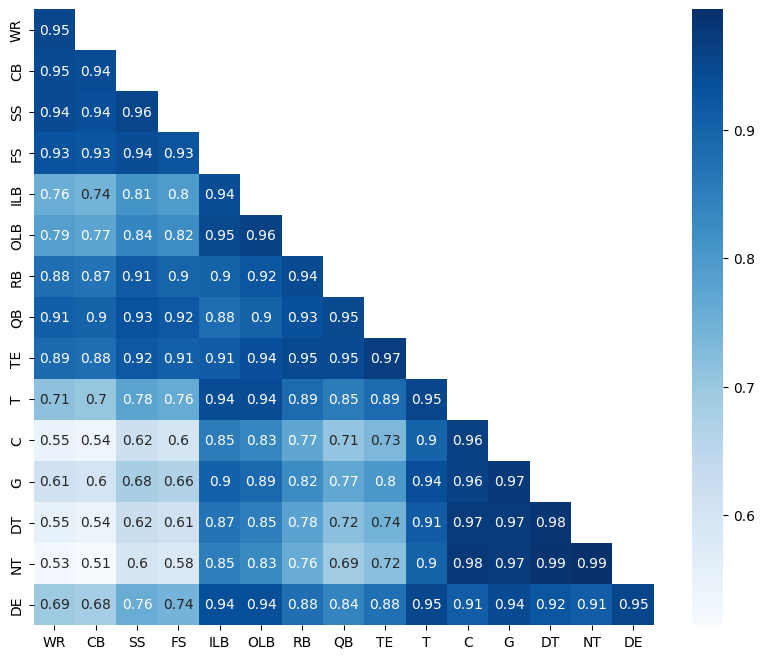

In [24]:
fig, ax = plt.subplots(figsize=(10,8))

#fig.suptitle(f"Similarity Between Positions", fontsize=15)
#corr= sim_32_dim.corr()
matrix = np.triu(sim_32_dim, 1)

sns.heatmap(sim_32_dim, annot=True, mask=matrix, ax=ax, cmap="Blues")
txt=f"\n Note the positions we would expect to be similar (FS, SS, CB) are similar, \n \
    while the positions we would expect to be dissimilar (e.g. CB & G) are dissimilar"
#plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=11)
# fig.tight_layout()
# plt.figtext(0.45, -0.06, txt, wrap=True, horizontalalignment='center', 
#             bbox=dict(boxstyle="square", facecolor="beige"), fontsize=11)

plt.savefig('similarity_32_dim_no_titles.png', bbox_inches='tight')
plt.show()

In [25]:
#sim_32_dim.iloc[:-4,:-4].to_csv("../statistics/report_data/similarity_32_dim.csv")

In [25]:
intra_pos_sim_3_dim = pd.DataFrame(np.diagonal(sim_3_dim), index=sim_3_dim.index).T

#intra_pos_sim_3_dim.to_csv("../statistics/report_data/intra_pos_similarity_3_dim.csv")

### Q2) McAffrey Example

In [ ]:
cmc_player_list = ['Christian McCaffrey', 'Cooper Kupp', 'Saquon Barkley', 'Derrick Henry', 'Cordarrelle Patterson', 'Zack Moss', 'James Cook', 'Mark Ingram', 'Leonard Fournette', 'Dalvin Cook', 'Isiah Pacheco', 'Cam Akers', 'Stefon Diggs', 'Gabe Davis', 'Brandon Powell', 'D.J. Chark', 'Tyler Boyd', 'Von Miller', 'Ed Oliver', 'Aaron Donald']
cmc_players_3_dim = embed_3_dim.loc[cmc_player_list]
cmc_players_9_dim = embed_9_dim.loc[cmc_player_list]
cmc_players_32_dim = embed_32_dim.loc[cmc_player_list]

In [18]:
get_similarity_df(cmc_players_3_dim).iloc[0:1,:]

displayName,Christian McCaffrey,Cooper Kupp,Saquon Barkley,Derrick Henry,Cordarrelle Patterson,Zack Moss,James Cook,Mark Ingram,Leonard Fournette,Dalvin Cook,Isiah Pacheco,Cam Akers,Stefon Diggs,Gabe Davis,Brandon Powell,D.J. Chark,Tyler Boyd,Von Miller,Ed Oliver,Aaron Donald
displayName,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1.0,0.870437,0.984685,0.981305,0.998529,0.984601,0.99855,0.995786,0.999917,0.998449,0.991251,0.995623,0.442514,0.518657,0.911993,0.148688,0.999786,0.991067,0.997327,0.997922


In [19]:
get_similarity_df(cmc_players_9_dim).iloc[0:10,:]

displayName,Christian McCaffrey,Cooper Kupp,Saquon Barkley,Derrick Henry,Cordarrelle Patterson,Zack Moss,James Cook,Mark Ingram,Leonard Fournette,Dalvin Cook,Isiah Pacheco,Cam Akers,Stefon Diggs,Gabe Davis,Brandon Powell,D.J. Chark,Tyler Boyd,Von Miller,Ed Oliver,Aaron Donald
displayName,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1.000000,0.977545,0.997597,0.997596,0.998619,0.992490,0.992733,0.997345,0.999228,0.995511,0.998256,0.980402,0.959582,0.940119,0.992836,0.947888,0.958422,0.985060,0.747044,0.914490
Cooper Kupp,0.977545,1.000000,0.986174,0.984436,0.981838,0.951994,0.973854,0.968054,0.979027,0.991978,0.982364,0.993376,0.981485,0.940824,0.989421,0.961947,0.993509,0.959524,0.603993,0.812624
Saquon Barkley,0.997597,0.986174,1.000000,0.996198,0.997558,0.985741,0.986460,0.990666,0.996009,0.997629,0.996578,0.982414,0.975660,0.956718,0.998457,0.963902,0.966487,0.976221,0.724454,0.896481
Derrick Henry,0.997596,0.984436,0.996198,1.000000,0.996636,0.983442,0.992580,0.994633,0.997651,0.998510,0.996701,0.988775,0.963731,0.933444,0.991629,0.945802,0.971395,0.982452,0.714186,0.891163
Cordarrelle Patterson,0.998619,0.981838,0.997558,0.996636,1.000000,0.990132,0.992833,0.995811,0.998733,0.995986,0.998033,0.984374,0.962254,0.941543,0.994543,0.950512,0.965258,0.985120,0.726036,0.902607
Zack Moss,0.992490,0.951994,0.985741,0.983442,0.990132,1.000000,0.988112,0.994428,0.992263,0.978144,0.987508,0.957143,0.928193,0.920671,0.977975,0.924175,0.927871,0.987320,0.789941,0.945804
James Cook,0.992733,0.973854,0.986460,0.992580,0.992833,0.988112,1.000000,0.997008,0.996322,0.988940,0.993055,0.986006,0.933318,0.900055,0.979013,0.918009,0.964366,0.997132,0.703475,0.893831
Mark Ingram,0.997345,0.968054,0.990666,0.994633,0.995811,0.994428,0.997008,1.000000,0.998289,0.989771,0.995009,0.978029,0.938831,0.916959,0.982869,0.928021,0.952033,0.992556,0.751092,0.920554
Leonard Fournette,0.999228,0.979027,0.996009,0.997651,0.998733,0.992263,0.996322,0.998289,1.000000,0.995386,0.998442,0.984260,0.954157,0.929508,0.990863,0.940098,0.963374,0.990211,0.730546,0.907359


In [20]:
get_similarity_df(cmc_players_32_dim).iloc[0:10,:]

displayName,Christian McCaffrey,Cooper Kupp,Saquon Barkley,Derrick Henry,Cordarrelle Patterson,Zack Moss,James Cook,Mark Ingram,Leonard Fournette,Dalvin Cook,Isiah Pacheco,Cam Akers,Stefon Diggs,Gabe Davis,Brandon Powell,D.J. Chark,Tyler Boyd,Von Miller,Ed Oliver,Aaron Donald
displayName,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1.000000,0.946917,0.988159,0.992789,0.994705,0.981891,0.989056,0.994421,0.998842,0.992071,0.994977,0.987262,0.915148,0.892076,0.958691,0.865257,0.950520,0.971111,0.806301,0.907851
Cooper Kupp,0.946917,1.000000,0.980358,0.927608,0.957258,0.913233,0.945040,0.917422,0.943148,0.969836,0.954207,0.957887,0.987089,0.977868,0.996781,0.965493,0.989240,0.897272,0.588207,0.738250
Saquon Barkley,0.988159,0.980358,1.000000,0.973459,0.991762,0.963765,0.980470,0.971273,0.986782,0.993779,0.990572,0.985708,0.957650,0.942337,0.987108,0.916869,0.973915,0.952459,0.725089,0.848132
Derrick Henry,0.992789,0.927608,0.973459,1.000000,0.987872,0.963157,0.975383,0.988308,0.991772,0.989266,0.984825,0.987879,0.899655,0.860087,0.939441,0.834953,0.940379,0.954609,0.810742,0.904771
Cordarrelle Patterson,0.994705,0.957258,0.991762,0.987872,1.000000,0.974305,0.982053,0.985430,0.992607,0.994379,0.993570,0.994591,0.932082,0.911883,0.969385,0.884765,0.961776,0.956724,0.775633,0.881902
Zack Moss,0.981891,0.913233,0.963765,0.963157,0.974305,1.000000,0.985869,0.991119,0.984032,0.959059,0.981055,0.957610,0.861718,0.857068,0.924778,0.823607,0.914733,0.985127,0.825852,0.926757
James Cook,0.989056,0.945040,0.980470,0.975383,0.982053,0.985869,1.000000,0.987502,0.991417,0.977835,0.991564,0.977607,0.895440,0.880775,0.952250,0.854582,0.949129,0.987233,0.769590,0.890615
Mark Ingram,0.994421,0.917422,0.971273,0.988308,0.985430,0.991119,0.987502,1.000000,0.995297,0.977673,0.989294,0.974899,0.875825,0.854109,0.930506,0.824736,0.923237,0.981230,0.843533,0.937121
Leonard Fournette,0.998842,0.943148,0.986782,0.991772,0.992607,0.984032,0.991417,0.995297,1.000000,0.990337,0.996336,0.985017,0.907509,0.883940,0.954097,0.855299,0.945828,0.978144,0.808942,0.912876


CMC is more similar to the Cooper Kupp than the average RB-WR pair

In [35]:
''' function that returns a player's average similarity to each player in an entire position '''
def player_pos_similarity(embed_df, pos_str, player_str):
    players_in_pos = embed_9_dim.query("position == @pos_str").index.values #array
    full_similarity = get_similarity_df(embed_df)
    similarity_row = full_similarity.loc[player_str, players_in_pos]
    return pd.DataFrame(similarity_row).T

In [ ]:
from scipy.stats import percentileofscore

In [448]:
embed_32_dim.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,nflId,position
displayName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
David Long,-0.243633,-1.308358,0.931337,1.118743,-0.412155,-1.061731,1.795956,0.832513,-0.748043,-0.194943,0.550681,-0.257446,0.292334,0.216967,-1.185289,-0.569765,-0.233435,1.363359,-0.375071,0.262129,0.473137,1.567027,2.262220,-1.115465,0.858981,-0.358569,-0.483874,0.889076,-0.186108,-0.864384,-1.078716,-0.465904,47862.0,CB
Gabe Davis,-0.919333,-3.708827,2.778434,2.686772,-0.806195,-2.849146,4.784183,1.752988,-1.802447,-0.241791,1.490319,-0.820288,0.764951,0.551439,-2.701238,-1.590109,-0.842738,3.175034,-0.596924,0.477496,1.185441,4.047108,6.126431,-2.909370,2.148940,-0.702132,-1.584896,2.274493,-0.531693,-2.783012,-3.001867,-1.341409,52536.0,WR
Nick Scott,-2.287931,-3.982921,3.226217,2.532299,-0.875158,-2.085616,5.495210,1.663377,-0.380239,-0.342056,1.842230,-0.227996,1.640130,-0.332317,-2.073540,-2.966493,-2.087404,3.249974,1.295730,1.613875,1.052569,4.650994,5.972294,-3.485752,1.469225,0.014704,-1.247068,1.030909,0.752968,-2.924782,-2.551167,-0.690713,48026.0,SS
Troy Hill,-0.638467,-1.512752,1.193222,0.985631,-0.287466,-0.993047,2.113661,0.616814,-0.374365,-0.036549,0.673225,-0.136352,0.493341,0.014431,-1.017876,-0.880506,-0.623563,1.354836,0.174403,0.485366,0.490503,1.753379,2.393044,-1.347015,0.708756,-0.238696,-0.527500,0.661850,0.134026,-1.062740,-1.173929,-0.354251,42816.0,CB
Isaiah McKenzie,-0.866931,-1.942861,1.549403,1.232511,-0.341335,-1.190664,2.518738,0.737017,-0.496450,-0.042837,0.903952,-0.271413,0.537997,0.140027,-0.945903,-1.070537,-0.806934,1.345081,0.238866,0.454410,0.703630,2.123123,2.901323,-1.518627,0.836108,-0.070935,-0.833204,0.736942,-0.065389,-1.575568,-1.427764,-0.567502,44985.0,WR


In [460]:
all_players_sim_avg_rb = np.zeros(len(embed_32_dim.index)-2)
all_players_sim_avg_wr = np.zeros(len(embed_32_dim.index)-2)

for index, player_name in enumerate(embed_32_dim.index[0:-2]):
    all_players_sim_avg_rb[index] = player_pos_similarity(embed_32_dim, 'RB', player_name).mean(axis=None)
    all_players_sim_avg_wr[index] = player_pos_similarity(embed_32_dim, 'WR', player_name).mean(axis=None)


In [544]:
full_similarity_32_dim = get_similarity_df(embed_32_dim)

In [552]:
cmc_player_list = ['Christian McCaffrey', 'Leonard Fournette', 'Austin Ekeler', 'Deebo Samuel', 'Curtis Samuel', 'Cooper Kupp', 'Tyler Boyd', 'Randall Cobb']


In [546]:
full_percentile_similarity_32_dim = pd.read_csv("../statistics/output_data/percentile_similarity_full_df.csv").set_index("displayName")

In [547]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.patches import Rectangle

In [646]:
def create_plot(names, ax, use_msk_1=True):
    report_df = full_percentile_similarity_32_dim.copy()
    report_df = report_df.loc[names, names]
    report_df['avg_wr'] = 1
    report_df['avg_rb'] = 1

    report_df.loc['avg_rb',:] = 0
    report_df.loc['avg_wr',:] = 0

    rb_rb, wr_wr, wr_rb, rb_wr = position_similarities('WR', 'RB', embed_32_dim)

    report_df.loc['avg_rb','avg_rb'] = rb_rb
    report_df.loc['avg_rb','avg_wr'] = rb_wr
    report_df.loc['avg_wr','avg_rb'] = wr_rb
    report_df.loc['avg_wr','avg_wr'] = wr_wr

    for player_name in report_df.index[0:-2]:
        player_rb_sim = player_pos_similarity(embed_32_dim, 'RB', player_name).mean(axis=None)
        player_wr_sim = player_pos_similarity(embed_32_dim, 'WR', player_name).mean(axis=None)

        report_df.loc['avg_rb',player_name] = player_rb_sim
        report_df.loc['avg_wr',player_name] = player_wr_sim

    avg_rb_percentiles = percentileofscore(all_players_sim_avg_rb, report_df.loc['avg_rb'])
    avg_wr_percentiles = percentileofscore(all_players_sim_avg_wr, report_df.loc['avg_wr'])

    report_df.loc['avg_rb'] = avg_rb_percentiles
    report_df.loc['avg_wr'] = avg_wr_percentiles

    #ax.add_patch(Rectangle((0.8,0), 0.1, 0.1, fill=False, edgecolor='green', lw=6))

    #matrix = np.triu(report_df.values, 1)
    if use_msk_1:
        matrix = ~np.array([
            [0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0],
            [1,1,1,0,0,0,0,0,0,0],
            [1,1,1,0,0,0,0,0,0,0],
            [1,1,1,0,0,0,0,0,0,0],
            [1,1,1,0,0,0,0,0,0,0],
            [1,1,1,0,0,0,0,0,0,0],
            [0,0,0,1,1,1,1,1,0,0],
            [1,1,1,0,0,0,0,0,0,1]
        ]).astype(np.bool_)
    else:
        matrix = ~np.array([
            [0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0],
            [1,1,1,1,0,0,0,0,0,0],
            [1,1,1,1,0,0,0,0,0,0],
            [1,1,1,1,0,0,0,0,0,0],
            [1,1,1,1,0,0,0,0,0,0],
            [0,0,0,0,1,1,1,1,0,0],
            [1,1,1,1,0,0,0,0,0,1]
        ]).astype(np.bool_)

    report_df.index.name = None

    rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
    #divnorm = TwoSlopeNorm(vmin=0, vcenter=wr_rb, vmax=100)
    if use_msk_1:
        sns.heatmap(report_df.astype(np.int32), ax=ax, annot=True, mask=matrix, cmap="RdYlBu", vmin=0, vmax=100, cbar=False, fmt='d', zorder=2)
    else:
        sns.heatmap(report_df.astype(np.int32), ax=ax, annot=True, mask=matrix, cmap="RdYlBu", vmin=0, vmax=100, cbar=True, fmt='d', zorder=2)
    


In [647]:
np.random.seed(29)

In [648]:
#random_wr = np.random.choice(embed_32_dim.query("position == 'WR'").index, 4)
#random_rb = np.random.choice(embed_32_dim.query("position == 'RB'").index, 4)

In [649]:
random_wr = ['CeeDee Lamb', 'DeVonta Smith', 'Amari Cooper', 'A.J. Green']
random_rb = ['Jaylen Warren','Rhamondre Stevenson', 'Zack Moss','A.J. Dillon']

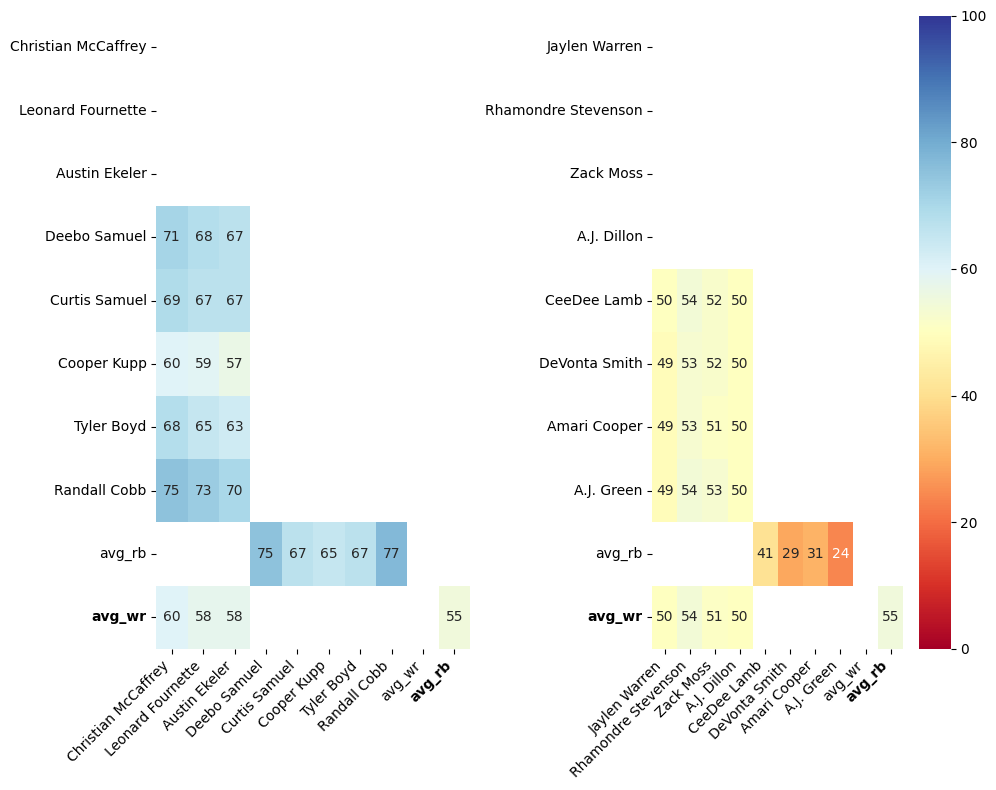

In [650]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))

create_plot(cmc_player_list, ax1, True)
create_plot(list(np.concatenate([random_rb, random_wr])), ax2, False)

#fig.suptitle(f"Similarity Between Players", fontsize=15)

ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')

#ax1.arrow(9, 8, .5, 0.5, width=.1, color='red', zorder=10)
#ax2.arrow(9, 8, .5, .5, width=.1, color='red', zorder=10)

labels = ax1.get_xticklabels()
for label in labels:
    if label.get_text() == 'avg_rb':
        label.set_fontweight('bold')
labels = ax2.get_xticklabels()
for label in labels:
    if label.get_text() == 'avg_rb':
        label.set_fontweight('bold')

labels = ax1.get_yticklabels()
for label in labels:
    if label.get_text() == 'avg_wr':
        label.set_fontweight('bold')
labels = ax2.get_yticklabels()
for label in labels:
    if label.get_text() == 'avg_wr':
        label.set_fontweight('bold')

# ax1.add_patch(Rectangle((9, 9), 1, 1, fill=False, edgecolor='red', lw=4,zorder=10))
# ax2.add_patch(Rectangle((9, 9), 1, 1, fill=False, edgecolor='red', lw=4,zorder=10))

#txt=f"The list"
#plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=11)
fig.tight_layout()
# plt.figtext(0.45, -0.06, txt, wrap=True, horizontalalignment='center', 
#             bbox=dict(boxstyle="square", facecolor="beige"), fontsize=11)


plt.savefig(f'similarity_between_players_heatmap.png', bbox_inches='tight')
plt.show()


In [186]:
report_df = full_percentile_similarity_32_dim.loc[cmc_player_list, cmc_player_list].copy()

In [187]:
report_df['avg_rb'] = 0
report_df['avg_wr'] = 0

report_df.loc['avg_rb',:] = 0
report_df.loc['avg_wr',:] = 0

In [188]:
# for player_name in report_df.index[0:-2]:
#     player_rb_sim = player_pos_similarity(embed_32_dim, 'RB', player_name).mean(axis=None)
#     player_wr_sim = player_pos_similarity(embed_32_dim, 'WR', player_name).mean(axis=None)

#     report_df.loc['avg_rb',player_name] = 
#     report_df.loc['avg_wr',player_name] = 

In [189]:
rb_rb, wr_wr, wr_rb, rb_wr = position_similarities('WR', 'RB', embed_32_dim)

report_df.loc['avg_rb','avg_rb'] = rb_rb
report_df.loc['avg_rb','avg_wr'] = rb_wr
report_df.loc['avg_wr','avg_rb'] = wr_rb
report_df.loc['avg_wr','avg_wr'] = wr_wr


In [190]:
for player_name in report_df.index[0:-2]:
    player_rb_sim = player_pos_similarity(embed_32_dim, 'RB', player_name).mean(axis=None)
    player_wr_sim = player_pos_similarity(embed_32_dim, 'WR', player_name).mean(axis=None)

    report_df.loc['avg_rb',player_name] = player_rb_sim
    report_df.loc['avg_wr',player_name] = player_wr_sim

In [191]:
all_players_sim_avg_rb.max()

0.9748512648253851

In [192]:
avg_rb_percentiles = percentileofscore(all_players_sim_avg_rb, report_df.loc['avg_rb'])
avg_wr_percentiles = percentileofscore(all_players_sim_avg_wr, report_df.loc['avg_wr'])

In [193]:
report_df.loc['avg_rb'] = avg_rb_percentiles
report_df.loc['avg_wr'] = avg_wr_percentiles

In [194]:
report_df.round(1)

,Christian McCaffrey,Leonard Fournette,Austin Ekeler,Cooper Kupp,Tyler Boyd,Randall Cobb,avg_rb,avg_wr
displayName,,,,,,,,
Christian McCaffrey,100.0,99.9,99.6,63.7,66.9,77.3,0.0,0.0
Leonard Fournette,99.9,100.0,99.5,57.6,59.5,71.0,0.0,0.0
Austin Ekeler,99.9,99.9,100.0,56.5,59.2,72.7,0.0,0.0
Cooper Kupp,60.8,59.4,58.0,100.0,93.7,91.1,0.0,0.0
Tyler Boyd,68.9,65.9,63.4,94.6,100.0,99.7,0.0,0.0
Randall Cobb,75.8,73.0,70.4,92.2,99.6,100.0,0.0,0.0
avg_rb,99.9,100.0,98.9,65.2,67.7,77.2,82.9,37.7
avg_wr,60.6,59.0,58.6,94.1,79.7,78.1,55.5,72.9


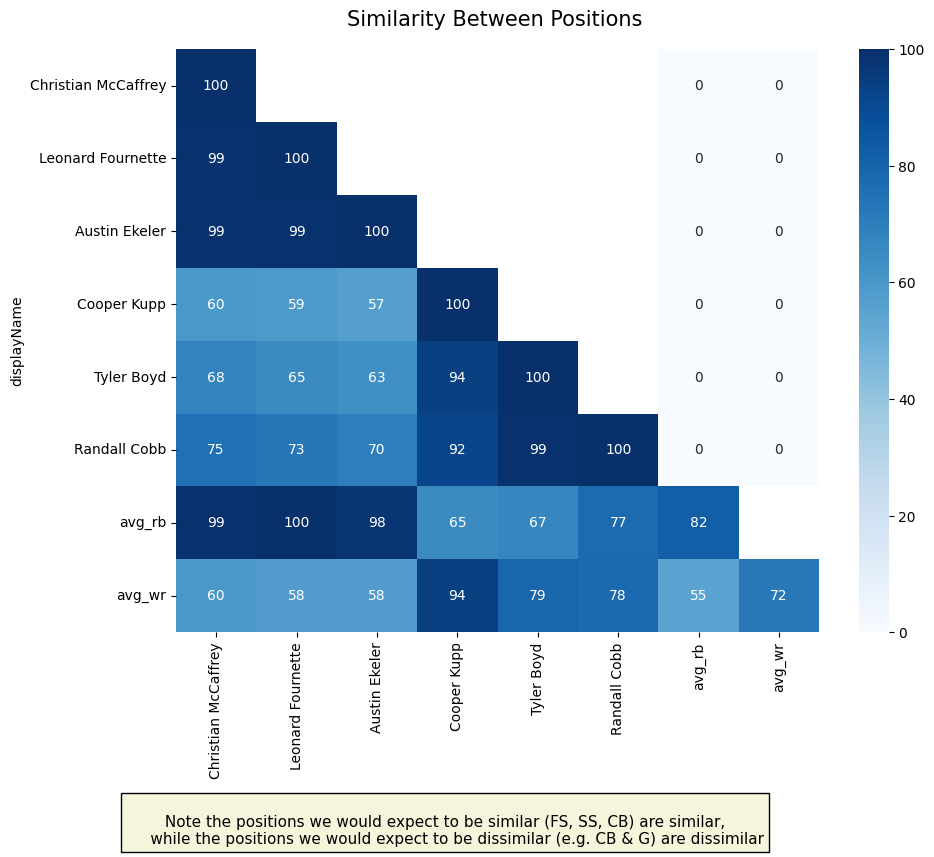

In [195]:
fig, ax = plt.subplots(figsize=(10,8))

fig.suptitle(f"Similarity Between Positions", fontsize=15)
#corr= sim_32_dim.corr()
matrix = np.triu(report_df, 1)

sns.heatmap(report_df.astype(np.int32), annot=True, mask=matrix, ax=ax, cmap="Blues", fmt='d')
txt=f"\n Note the positions we would expect to be similar (FS, SS, CB) are similar, \n \
    while the positions we would expect to be dissimilar (e.g. CB & G) are dissimilar"
#plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=11)
fig.tight_layout()
plt.figtext(0.45, -0.06, txt, wrap=True, horizontalalignment='center', 
            bbox=dict(boxstyle="square", facecolor="beige"), fontsize=11)

#plt.savefig('similarity_32_dim.png', bbox_inches='tight')
plt.show()

In [209]:
print(f"Tyler Boyd average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'RB', 'Tyler Boyd').mean(axis=1).item()}")
print(f"Cooper Kupp average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'RB', 'Cooper Kupp').mean(axis=1).item()}")
print(f"Randall Cobb average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'RB', 'Randall Cobb').mean(axis=1).item()}")


Tyler Boyd average similarity with wide receivers = 0.930861162063043
Cooper Kupp average similarity with wide receivers = 0.928216603129064
Randall Cobb average similarity with wide receivers = 0.9432144762075737


In [183]:
print(f"McAffrey average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'WR', 'Christian McCaffrey').mean(axis=1).item()}")
print(f"Austin Ekeler average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'WR', 'Austin Ekeler').mean(axis=1).item()}")
print(f"Fournette average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'WR', 'Leonard Fournette').mean(axis=1).item()}")
print(f"")
print(f"Jamaal Williams average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'WR', 'Jamaal Williams').mean(axis=1).item()}")
print(f"Kyle Juszczyk average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'WR', 'Kyle Juszczyk').mean(axis=1).item()}")
print(f"Elijah Mitchell average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'WR', 'Elijah Mitchell').mean(axis=1).item()}")
print(f"Cam Akers average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'WR', 'Cam Akers').mean(axis=1).item()}")
print(f"Khalil Herbert average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'WR', 'Khalil Herbert').mean(axis=1).item()}")
print(f"Tyler Allgeier average similarity with wide receivers = {player_pos_similarity(embed_32_dim, 'WR', 'Tyler Allgeier').mean(axis=1).item()}")

	

McAffrey average similarity with wide receivers = 0.9047739677328435
Austin Ekeler average similarity with wide receivers = 0.8963850750348915
Fournette average similarity with wide receivers = 0.8982236764774024

Jamaal Williams average similarity with wide receivers = 0.8963672870682166
Kyle Juszczyk average similarity with wide receivers = 0.9323987809868081
Elijah Mitchell average similarity with wide receivers = 0.9545945638260811
Cam Akers average similarity with wide receivers = 0.9207795453185478
Khalil Herbert average similarity with wide receivers = 0.8833086838631268
Tyler Allgeier average similarity with wide receivers = 0.8955022485337365


In [23]:
mcaffrey_wr_similarity = player_pos_similarity(embed_32_dim, 'WR', 'Christian McCaffrey').mean(axis=1).item()
kupp_rb_similarity = player_pos_similarity(embed_32_dim, 'RB', 'Cooper Kupp').mean(axis=1).item()
samuel_rb_similarity = player_pos_similarity(embed_32_dim, 'RB', 'Deebo Samuel').mean(axis=1).item()
samuel_wr_similarity = player_pos_similarity(embed_32_dim, 'WR', 'Deebo Samuel').mean(axis=1).item()


In [24]:
print(f"McAffrey average similarity with wide receivers = {mcaffrey_wr_similarity}")
print(f"Kupp average similarity with RB = {kupp_rb_similarity}")
print(f"Kupp-McAffrey similarity = {full_similarity_32_dim.loc['Christian McCaffrey', 'Cooper Kupp']}")

McAffrey average similarity with wide receivers = 0.9047739677328435
Kupp average similarity with RB = 0.928216603129064
Kupp-McAffrey similarity = 0.9469169337193446


In [25]:
print(f"McAffrey average similarity with wide receivers = {mcaffrey_wr_similarity}")
print(f"Deebo average similarity with RB = {samuel_rb_similarity}")
print(f"Deebo average similarity with WR = {samuel_wr_similarity}")
print(f"Deebo-McAffrey similarity = {full_similarity_32_dim.loc['Christian McCaffrey', 'Deebo Samuel']}")

McAffrey average similarity with wide receivers = 0.9047739677328435
Deebo average similarity with RB = 0.940816720193724
Deebo average similarity with WR = 0.9625030434519023
Deebo-McAffrey similarity = 0.9618976094148827


In [177]:
curtis_samuel_wr_similarity = player_pos_similarity(embed_32_dim, 'WR', 'Curtis Samuel').mean(axis=1).item()
curtis_samuel_rb_similarity = player_pos_similarity(embed_32_dim, 'RB', 'Curtis Samuel').mean(axis=1).item()

print(f"Curtis Samuel average similarity with wide receivers = {curtis_samuel_wr_similarity}")
print(f"Curtis Samuel average similarity with RB = {curtis_samuel_rb_similarity}")
print(f"Curtis_Samuel-McAffrey similarity = {full_similarity_32_dim.loc['Christian McCaffrey', 'Curtis Samuel']}")

Curtis Samuel average similarity with wide receivers = 0.956246880122736
Curtis Samuel average similarity with RB = 0.9308743733056493
Curtis_Samuel-McAffrey similarity = 0.9514174182030037


In [26]:
henry_wr_similarity = player_pos_similarity(embed_32_dim, 'WR', 'Derrick Henry').mean(axis=1).item()
print(f"Henry average similarity with wide receivers = {henry_wr_similarity}")
print(f"Deebo-Henry similarity = {full_similarity_32_dim.loc['Derrick Henry', 'Deebo Samuel']}")
print(f"Kupp-Henry similarity = {full_similarity_32_dim.loc['Derrick Henry', 'Cooper Kupp']}")

Henry average similarity with wide receivers = 0.8882221311906631
Deebo-Henry similarity = 0.9585095868093473
Kupp-Henry similarity = 0.9276079124272999


In [179]:
smith_wr_similarity = player_pos_similarity(embed_32_dim, 'RB', 'DeVonta Smith').mean(axis=1).item()
print(f"Derrick Henry average similarity with wide receivers = {henry_wr_similarity}")
print(f"Devonta Smith average similarity with running backs = {smith_wr_similarity}")
print(f"Smith-Henry similarity = {full_similarity_32_dim.loc['Derrick Henry', 'DeVonta Smith']}")

Henry average similarity with wide receivers = 0.8882221311906631
Devonta Smith average similarity with running backs = 0.854170426640821
Smith-Henry similarity = 0.8425566491540967


In [210]:
# niners_ids = ngs_df.query("team == 'SF'").nflId.unique()
# players.query("nflId in @niners_ids")

In [28]:
print(f"Kupp-Akers similarity = {full_similarity_32_dim.loc['Cam Akers', 'Cooper Kupp']}")

Kupp-Akers similarity = 0.957886990318114


In [29]:
print(f"Kupp-Akers similarity = {full_similarity_32_dim.loc['Laken Tomlinson', 'Cooper Kupp']}")

Kupp-Akers similarity = 0.6794091966015009


### Q3) Graph 3-dim

In [30]:
embed_3_dim.head()

,0,1,2,nflId,position
displayName,,,,,
Gabe Davis,6.891518,-9.983031,1.058315,52536.0,WR
David Long,4.206648,-2.269063,-1.535677,47862.0,CB
Nick Scott,1.047610,-2.469913,0.177523,48026.0,SS
Troy Hill,1.914106,-0.806077,-1.223706,42816.0,CB
Isaiah McKenzie,0.798776,-4.780803,1.657559,44985.0,WR


In [88]:
embed_3_dim.query("position == 'QB'").index

Index(['Josh Allen', 'Matthew Stafford', 'Marcus Mariota', 'Jameis Winston',
       'Jacoby Brissett', 'Baker Mayfield', 'Trey Lance', 'Justin Fields',
       'Mitchell Trubisky', 'Joe Burrow', 'Jalen Hurts', 'Jared Goff',
       'Matt Ryan', 'Davis Mills', 'Jeff Driskel', 'Tua Tagovailoa',
       'Mac Jones', 'Lamar Jackson', 'Joe Flacco', 'Daniel Jones',
       'Ryan Tannehill', 'Carson Wentz', 'Trevor Lawrence', 'Kyler Murray',
       'Patrick Mahomes', 'Chad Henne', 'Trace McSorley', 'Derek Carr',
       'Justin Herbert', 'Aaron Rodgers', 'Kirk Cousins', 'Jordan Love',
       'Tom Brady', 'Dak Prescott', 'Cooper Rush', 'Geno Smith',
       'Russell Wilson', 'Chase Daniel', 'Nick Foles', 'Jimmy Garoppolo',
       'Case Keenum', 'Malik Willis', 'Teddy Bridgewater', 'Andy Dalton',
       'Tyrod Taylor', 'Kenny Pickett', 'Zach Wilson', 'Bailey Zappe',
       'Brian Hoyer', 'Skylar Thompson', 'Phillip Walker', 'Jacob Eason',
       'Taylor Heinicke', 'Brett Rypien', 'Jarrett Stidham', '

In [89]:
rb_list = ['Christian McCaffrey', 'Saquon Barkley', 'Derrick Henry', 'Cordarrelle Patterson', 'Zack Moss', 'James Cook', 'Mark Ingram', 'Leonard Fournette', 'Dalvin Cook', 'Isiah Pacheco', 'Cam Akers']
qb_list = ['Patrick Mahomes', 'Josh Allen', 'Matthew Stafford', 'Justin Fields', 'Kyler Murray', 'Trey Lance',
       'Mitchell Trubisky', 'Joe Burrow', 'Marcus Mariota', 'Jameis Winston',
       'Jacoby Brissett', 'Baker Mayfield']

Dimension 2 is the slot dimension. Doesn't change for QB and RB, has variability for WR and CB

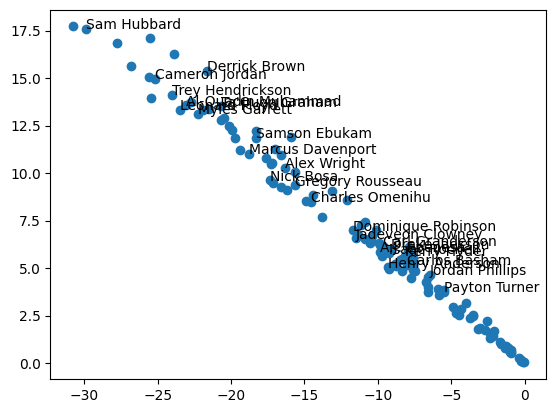

In [111]:
plot_df = embed_3_dim.drop('Football')
plot_df = plot_df.query("position == 'DE'")
plot_df = plot_df.drop(['nflId', 'position'],axis=1)

dim1 = 1
dim2 = 2
num_to_plot=25
#fig, (ax,ax2) = plt.subplots(1, 2, figsize=(self.FIG_WIDTH, self.FIG_HEIGHT))
fig, ax = plt.subplots(1, 1)
ax.scatter(plot_df.iloc[:,dim1], plot_df.iloc[:,dim2], )

# for i, txt_name in enumerate(qb_list):
#     ax.annotate(txt_name, (plot_df.loc[txt_name,str(dim1)], plot_df.loc[txt_name,str(dim2)]))


for i, txt_name in enumerate(plot_df.index[0:num_to_plot]):
    ax.annotate(txt_name, (plot_df.iloc[i,dim1], plot_df.iloc[i,dim2]))

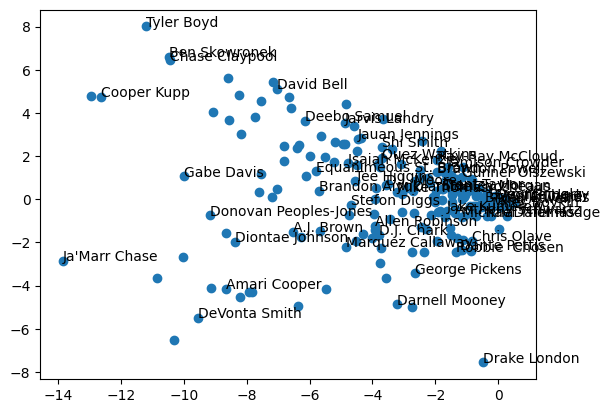

In [101]:
plot_df = embed_3_dim.drop('Football')
plot_df = plot_df.query("position == 'WR'")
plot_df = plot_df.drop(['nflId', 'position'],axis=1)

dim1 = 1
dim2 = 2
num_to_plot=50
#fig, (ax,ax2) = plt.subplots(1, 2, figsize=(self.FIG_WIDTH, self.FIG_HEIGHT))
fig, ax = plt.subplots(1, 1)
ax.scatter(plot_df.iloc[:,dim1], plot_df.iloc[:,dim2], )

# for i, txt_name in enumerate(qb_list):
#     ax.annotate(txt_name, (plot_df.loc[txt_name,str(dim1)], plot_df.loc[txt_name,str(dim2)]))


for i, txt_name in enumerate(plot_df.index[0:num_to_plot]):
    ax.annotate(txt_name, (plot_df.iloc[i,dim1], plot_df.iloc[i,dim2]))



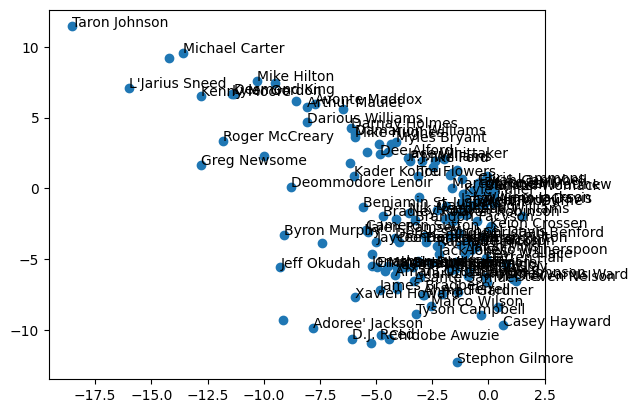

In [106]:
plot_df = embed_3_dim.drop('Football')
plot_df = plot_df.query("position == 'CB'")
plot_df = plot_df.drop(['nflId', 'position'],axis=1)

dim1 = 1
dim2 = 2
num_to_plot=90
#fig, (ax,ax2) = plt.subplots(1, 2, figsize=(self.FIG_WIDTH, self.FIG_HEIGHT))
fig, ax = plt.subplots(1, 1)
ax.scatter(plot_df.iloc[:,dim1], plot_df.iloc[:,dim2], )

# for i, txt_name in enumerate(qb_list):
#     ax.annotate(txt_name, (plot_df.loc[txt_name,str(dim1)], plot_df.loc[txt_name,str(dim2)]))


for i, txt_name in enumerate(plot_df.index[0:num_to_plot]):
    ax.annotate(txt_name, (plot_df.iloc[i,dim1], plot_df.iloc[i,dim2]))

In [25]:
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering

In [26]:
embed_32_dropped = embed_32_dim[~embed_32_dim.index.duplicated(keep='first')].drop(columns=['nflId', 'position'])

In [27]:
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(embed_32_dropped)

In [28]:
node_embeddings_2d_df = pd.DataFrame(data=node_embeddings_2d, index=embed_32_dropped.index)

In [29]:
clustering_five = SpectralClustering(n_clusters=5, assign_labels="cluster_qr", random_state=0).fit(node_embeddings_2d_df)

In [30]:
node_embeddings_2d_df['labels'] = clustering_five.labels_

In [54]:
# from utils import importOrReload

# importOrReload("design")

In [31]:
import sys
sys.path.append('../')

from design import color_dict

label 3 = (0, 0.5686274509803921, 0.43137254901960786, 0.6)
label 1 = (0.13725490196078433, 0.3411764705882353, 0.5372549019607843, 0.6)
label 4 = (0.9450980392156862, 0.8274509803921568, 0.00784313725490196, 0.6)
label 2 = (0.7568627450980392, 0.1607843137254902, 0.1803921568627451, 0.6)
label 0 = (0.3843137254901961, 0.10588235294117647, 0, 0.6)


/var/folders/_w/4wq7jf9n3c74v00gxl_2v81r0000gn/T/ipykernel_19485/1592737532.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(label_embed.loc[:,0], label_embed.loc[:,1],


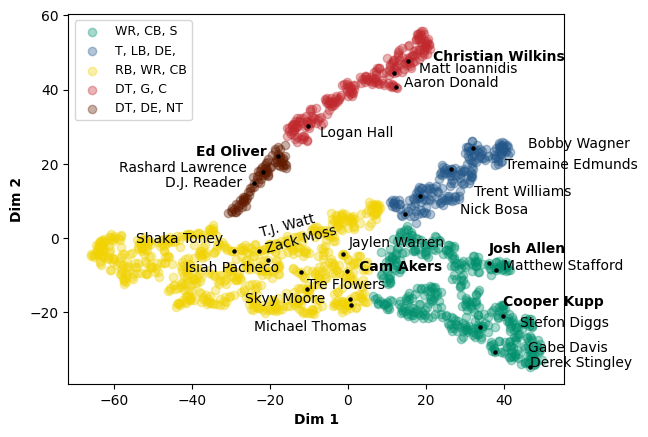

In [51]:
# interesting seeds - 5,8
np.random.seed(230)

color_map = {0:color_dict['brown_rgb'],
             1:color_dict['blue_rgb'],
             2:color_dict['red_rgb'],
             3:color_dict['green_rgb'],
             4:color_dict['yellow_rgb']}

label_map = {0:'DT, DE, NT',
             1:'T, LB, DE, ',
             2:'DT, G, C',
             3:'WR, CB, S',
             4:'RB, WR, CB', }

fig, ax = plt.subplots(1, 1)
#fig.suptitle(f"Clustered 2-D Projection of Positional Embeddings ")

for label in node_embeddings_2d_df.labels.unique():
    label_embed = node_embeddings_2d_df.query("labels == @label")
    print(f"label {label} = {color_map[label]}")
    ax.scatter(label_embed.loc[:,0], label_embed.loc[:,1], 
                     c=color_map[label],  label=label_map[label], alpha=0.35)

    num_to_plot=0

    names_to_plot_index = np.random.choice(label_embed.shape[0], size=num_to_plot)
    names_to_plot = label_embed.index[names_to_plot_index]

    for i, name in enumerate(names_to_plot):
        
        if name in []:
            ax.annotate(name, (label_embed.loc[name,0].item()-20, label_embed.loc[name,1].item() ))
        else:
            ax.annotate(name, (label_embed.loc[name,0].item(), label_embed.loc[name,1].item() ))

# names_to_plot=['Lamar Jackson', 'Derek Stingley', 'Matt Ioannidis','Aaron Donald', 'T.J. Watt',
#                'Keenan Allen', 'Anthony Pittman', 'Zack Moss',
#                 'Trent Williams', 'Nick Bosa', 'Christian Wilkins',
#                 'Bobby Wagner', 'Tremaine Edmunds', 'Ed Oliver', 'Gabe Davis', 'Stefon Diggs',
#                 'Logan Hall', 'Rashard Lawrence', 'Trey Flowers', 'Brock Purdy', 'Joe Flacco',
#                 'Josh Allen', 'Matthew Stafford']
        
names_to_plot=['Matt Ioannidis','Aaron Donald', 'T.J. Watt', 'Cooper Kupp', 'D.J. Reader',
               'Michael Thomas', 'Cam Akers', 'Zack Moss', 'Jaylen Warren', 'Derek Stingley',
                'Trent Williams', 'Nick Bosa', 'Christian Wilkins',
                'Bobby Wagner', 'Tremaine Edmunds', 'Ed Oliver', 'Gabe Davis', 'Stefon Diggs',
                'Logan Hall', 'Rashard Lawrence', 'Isiah Pacheco', 'Shaka Toney', 'Skyy Moore',
                'Josh Allen', 'Matthew Stafford', 'Tre Flowers']
for i, name in enumerate(names_to_plot):
    if name in ['Isiah Pacheco']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item()-30, node_embeddings_2d_df.loc[name,1].item() ))
    elif name in ['Rashard Lawrence']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item()-37, node_embeddings_2d_df.loc[name,1].item() ))
    elif name in ['Ed Oliver']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item()-21, node_embeddings_2d_df.loc[name,1].item() ), fontweight='bold')
    elif name in ['Rashard Lawrence']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item()-21, node_embeddings_2d_df.loc[name,1].item() ))
    elif name in ['Josh Allen', 'Cooper Kupp']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item(), node_embeddings_2d_df.loc[name,1].item()+2.7), fontweight='bold')
    elif name in ['Logan Hall']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item() + 3, node_embeddings_2d_df.loc[name,1].item() - 3))
    elif name in ['Aaron Donald']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item() + 2, node_embeddings_2d_df.loc[name,1].item()))
    elif name in ['Christian Wilkins']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item() + 6.5, node_embeddings_2d_df.loc[name,1].item()), fontweight='bold')
    elif name in ['Matt Ioannidis']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item() + 6.5, node_embeddings_2d_df.loc[name,1].item()))
    elif name in ['Jaylen Warren']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item() + 1.5, node_embeddings_2d_df.loc[name,1].item() + 2))
    elif name in ['D.J. Reader']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item() - 23, node_embeddings_2d_df.loc[name,1].item() - 1))
    elif name in ['Matthew Stafford']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item() + 1.8, node_embeddings_2d_df.loc[name,1].item() ))
    elif name in ['Bobby Wagner', 'Tremaine Edmunds', 'Trent Williams', 'Nick Bosa']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item() + 14, node_embeddings_2d_df.loc[name,1].item() ))
    elif name in ['Michael Thomas']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item() - 25, node_embeddings_2d_df.loc[name,1].item()-7 ))
    elif name in ['T.J. Watt']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item(), node_embeddings_2d_df.loc[name,1].item() + 4), ha='left', rotation=15)
    elif name in ['Shaka Toney']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item()-25, node_embeddings_2d_df.loc[name,1].item() + 2))
    elif name in ['Cam Akers']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item()+3, node_embeddings_2d_df.loc[name,1].item() ), fontweight='bold')
    elif name in ['Skyy Moore']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item()-27, node_embeddings_2d_df.loc[name,1].item()- 1))
    elif name in ['Zack Moss']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item() - 1, node_embeddings_2d_df.loc[name,1].item() + 2), ha='left', rotation=15 )
    elif name in ['Stefon Diggs']: # move name left to display better
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item()+10.1, node_embeddings_2d_df.loc[name,1].item()) )
    elif name in ['Gabe Davis']: # move name left to display better
        ax.annotate('Gabe Davis', (node_embeddings_2d_df.loc[name,0].item()+8.3, node_embeddings_2d_df.loc[name,1].item()) )
    
    else:
        ax.annotate(name, (node_embeddings_2d_df.loc[name,0].item(), node_embeddings_2d_df.loc[name,1].item() ))
    ax.scatter(node_embeddings_2d_df.loc[name,0].item(), node_embeddings_2d_df.loc[name,1].item(), color='black', s=5)

# legend_string = ""
# for label, descrip in label_map.items():
#     legend_string += f"dd"
# ax.text(-65, 55, legend_string, fontsize = 8, 
#         bbox=dict(boxstyle="square", facecolor="white"),
#         c = 'black')

ax.legend(scatterpoints=1, loc='upper left', fontsize=9)
ax.set_xlabel("Dim 1", fontweight='bold')
ax.set_ylabel("Dim 2", fontweight='bold')

# pos_text = f"We can visually inspect player vectors by projecting them into a 2-D vector space using the t-SNE \
# algorithm. We can identify similar groups within this space using spectral clustering."
# plt.figtext(0.5, -0.10, pos_text, wrap=True, horizontalalignment='center',
#             bbox=dict(boxstyle="square", facecolor="beige"), fontsize=11)
#fig.tight_layout()

plt.savefig('../statistics/report_data/embeddings_32_dim_cluster_plot_no_titles.png', bbox_inches='tight')

In [64]:
k=0
node_embeddings_2d_df.query("labels == 0").iloc[40*k:(40+40*k),:]

,0,1,labels
displayName,,,
Carlos Basham,-15.903307,19.843296,0
Ed Oliver,-18.093454,22.042786,0
Marquise Copeland,-17.443096,21.537529,0
Greg Van Roten,-22.584911,18.092670,0
Anthony Rush,-23.386019,15.832063,0
Matt Dickerson,-30.006435,7.316210,0
Colby Gossett,-26.707237,10.582812,0
Bravvion Roy,-20.925758,18.405333,0
Perrion Winfrey,-19.868357,19.279854,0


In [51]:
# inspect green labels 

node_embeddings_2d_df.query("labels == 2").index

Index(['Carlos Basham', 'Ed Oliver', 'Marquise Copeland', 'Greg Van Roten',
       'Anthony Rush', 'Matt Dickerson', 'Colby Gossett', 'Bravvion Roy',
       'Perrion Winfrey', 'Javon Kinlaw', 'Arik Armstead', 'Kerry Hyder',
       'Drake Jackson', 'D.J. Reader', 'Montravius Adams', 'Benito Jones',
       'Logan Stenberg', 'Michael Brockers', 'John Cominsky',
       'Michael Dwumfour', 'Byron Cowart', 'Justin Britt', 'Justin McCray',
       'Eric Johnson', 'Carl Davis', 'James Ferentz', 'John Jenkins',
       'Robert Jones', 'Michael Pierce', 'Brent Urban', 'DeMarcus Walker',
       'Kevin Strong', 'D.J. Davidson', 'Chase Roullier', 'Daniel Wise',
       'Wes Schweitzer', 'Adam Gotsis', 'Nick Allegretti', 'Rashard Lawrence',
       'Jonathan Ledbetter', 'Tershawn Wharton', 'Max Garcia', 'Lecitus Smith',
       'Lester Cotton', 'John Simpson', 'Otito Ogbonnia', 'Jake Hanson',
       'Devonte Wyatt', 'James Lynch', 'Ross Blacklock', 'Chauncey Golston',
       'Akiem Hicks', 'Trysten Hill'

In [53]:
players.head()

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger
2,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
3,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
4,30078,6-2,228,1982-11-24,Harvard,QB,Ryan Fitzpatrick


In [58]:
def plot_label(label):
    label_df = node_embeddings_2d_df.query("labels == @label")
    label_df = pd.merge(label_df, players.loc[:, ['displayName', 'officialPosition']], left_index=True, right_on='displayName')
    return (label_df.officialPosition.value_counts()/label_df.shape[0]).plot.bar()

In [61]:
def plot_label(label, axis):
    label_df = node_embeddings_2d_df.query("labels == @label")
    label_df = pd.merge(label_df, players.loc[:, ['displayName', 'officialPosition']], left_index=True, right_on='displayName')
    axis.bar(label_df.officialPosition.value_counts().index, label_df.officialPosition.value_counts()/label_df.shape[0],
             color = color_map[label])

    axis.set_title(f"cluster {label}")#: {color_map[label]}")
    axis.set_xticklabels(label_df.officialPosition.value_counts().index,rotation=45, ha='right')
    #return (label_df.officialPosition.value_counts()/label_df.shape[0]).plot.bar()

/var/folders/_w/4wq7jf9n3c74v00gxl_2v81r0000gn/T/ipykernel_3846/2404744717.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(label_df.officialPosition.value_counts().index,rotation=45, ha='right')
/var/folders/_w/4wq7jf9n3c74v00gxl_2v81r0000gn/T/ipykernel_3846/2404744717.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(label_df.officialPosition.value_counts().index,rotation=45, ha='right')
/var/folders/_w/4wq7jf9n3c74v00gxl_2v81r0000gn/T/ipykernel_3846/2404744717.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(label_df.officialPosition.value_counts().index,rotation=45, ha='right')
/var/folders/_w/4wq7jf9n3c74v00gxl_2v81r0000gn/T/ipykernel_3846/2404744717.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(label_df.officialPosition.value_counts().index,rotation=45, ha='righ

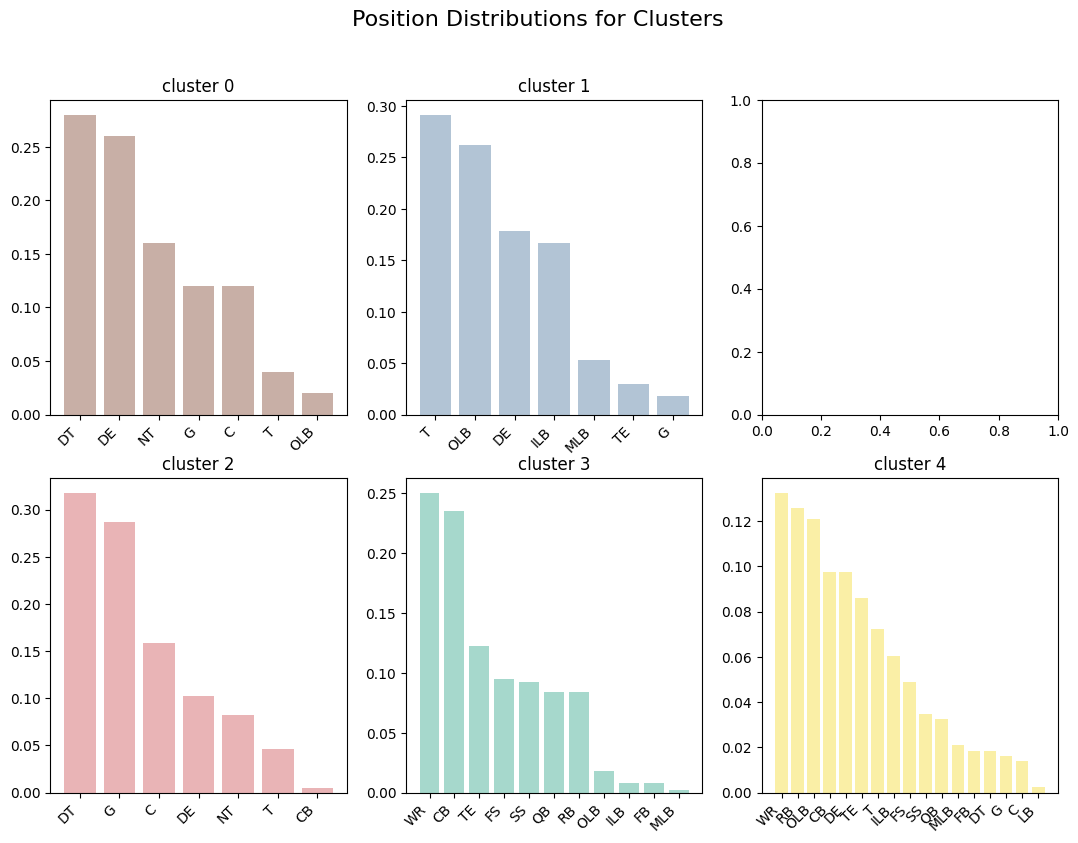

In [63]:
fig, axes = plt.subplots(2,3, figsize=(13,9))
fig.suptitle('Position Distributions for Clusters', fontsize=16)
plot_label(0, axes[0,0])
plot_label(1, axes[0,1])
plot_label(2, axes[1,0])
plot_label(3, axes[1,1])
plot_label(4, axes[1,2])

plt.savefig('../statistics/report_data/embeddings_32_dim_cluster_pos_dis.png', bbox_inches='tight')

In [117]:
names_to_plot=['Tristan Wirfs', 'Lamar Jackson', 'Derek Stingley', 'Calais Campbell', 'Matt Ioannidis',
                'Tyler Conklin', 'Zach Martin', 'Bobby Wagner', 'Tremaine Edmunds', 'Ed Oliver', 'Gabe Davis', 'Stefon Diggs']

In [166]:
bottom_left_quadrant_names = ['Zack Moss', 'Chuba Hubbard', 'Elijah Mitchell', 'T.J. Watt', 'Donald Parham',
                        'Azeez Al-Shaair', 'Nakobe Dean', 'Trace McSorley', 'Jordan Love',
                        'Tyrod Taylor', 'Case Keenum', 'Brock Purdy', 'Gardner Minshew',
                        'Keenan Allen', 'Anthony Pittman', 'Rashid Shaheed', 'DeSean Jackson']
upper_quadrant_names = ['Aaron Donald', 'Jadeveon Clowney', 'Trent Williams', 'Nick Bosa',
              'Arik Armstead', 'Kevin Dotson', 'Cameron Heyward', 'D.J. Reader', 
              'Josh Sweat', 'Fletcher Cox', 'Grover Stewart', 'Christian Wilkins',
              'Laken Tomlinson', 'Calais Campbell', 'Dexter Lawrence', 'Leonard Williams', 
              'Vita Vea']

In [245]:
node_embeddings_2d_df = pd.DataFrame(data=node_embeddings_2d, index=embed_32_dim.index)
node_embeddings_2d_df = node_embeddings_2d_df[~node_embeddings_2d_df.index.duplicated(keep='first')]


Names To Plot index = [ 74  99 248 304 358]
Names To Plot = ['Jeremy Reaves' 'Zander Horvath' 'Tevin Coleman' 'Jacob Eason'
 'T.Y. McGill']


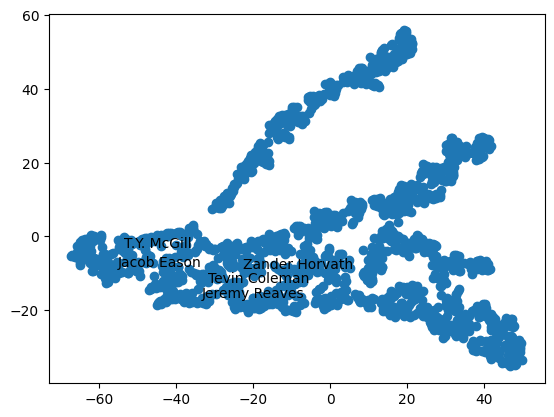

In [156]:

subset_msk = (node_embeddings_2d[:,0] < -20) & (node_embeddings_2d[:,1] < 0)
embeds = node_embeddings_2d[subset_msk]
names = embed_32_dim.index.values[subset_msk]
NUM_TO_PLOT=5

fig, ax = plt.subplots(1, 1)
ax.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1])
num_to_plot=50

names_to_plot_index = np.random.choice(len(names), size=NUM_TO_PLOT)
names_to_plot = names[names_to_plot_index]
print(f"Names To Plot index = {names_to_plot_index}")
print(f"Names To Plot = {names_to_plot}")

for i, index in enumerate(names_to_plot_index):
    ax.annotate(names_to_plot[i], (embeds[index,0], embeds[index,1] ))


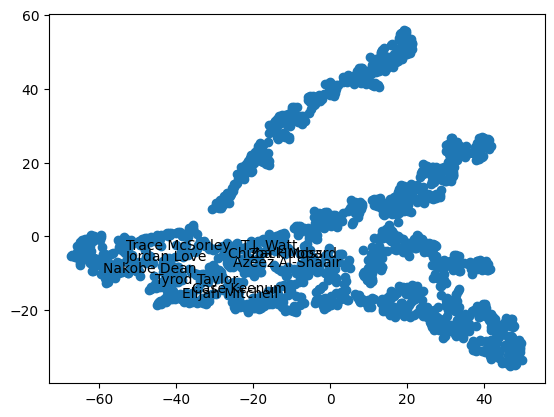

In [170]:

fig, ax = plt.subplots(1, 1)
ax.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1])
num_to_plot=50

for i, name in enumerate(bottom_left_quadrant[0:10]):
    ax.annotate(name, (node_embeddings_2d_df.loc[name, 0].item(), node_embeddings_2d_df.loc[name, 1].item()))

In [246]:
from sklearn.cluster import SpectralClustering

In [247]:
clustering = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=0).fit(node_embeddings_2d_df)

In [248]:
clustering.labels_

array([4, 4, 4, ..., 1, 1, 1])

In [249]:
node_embeddings_2d_df.query("labels == 0")

UndefinedVariableError: name 'labels' is not defined

label 2 (green) - Nick Bosa, T.J. Watt, Danielle Hunter, Orlando Brown
label 4 (goldenrod) - grover stewart, aaron donald
label 0 (aqua) - Devante Adams, Amon-Ra St. Brown, T.J. Hockenson, Cooper Kupp
label 3 (pink) - trey flowers

In [242]:
node_embeddings_2d_df.query("labels == 3").index

Index(['Carlos Basham', 'Ed Oliver', 'Marquise Copeland', 'Greg Van Roten',
       'Anthony Rush', 'Matt Dickerson', 'Colby Gossett', 'Bravvion Roy',
       'Perrion Winfrey', 'Javon Kinlaw', 'Arik Armstead', 'Kerry Hyder',
       'Drake Jackson', 'D.J. Reader', 'Montravius Adams', 'Benito Jones',
       'Logan Stenberg', 'Michael Brockers', 'John Cominsky',
       'Michael Dwumfour', 'Byron Cowart', 'Justin Britt', 'Justin McCray',
       'Eric Johnson', 'Carl Davis', 'James Ferentz', 'John Jenkins',
       'Robert Jones', 'Michael Pierce', 'Brent Urban', 'DeMarcus Walker',
       'Kevin Strong', 'D.J. Davidson', 'Chase Roullier', 'Daniel Wise',
       'Wes Schweitzer', 'Adam Gotsis', 'Nick Allegretti', 'Rashard Lawrence',
       'Jonathan Ledbetter', 'Tershawn Wharton', 'Max Garcia', 'Lecitus Smith',
       'Lester Cotton', 'John Simpson', 'Otito Ogbonnia', 'Jake Hanson',
       'Devonte Wyatt', 'James Lynch', 'Ross Blacklock', 'Chauncey Golston',
       'Akiem Hicks', 'Trysten Hill'

ValueError: 'c' argument has 1673 elements, which is inconsistent with 'x' and 'y' with size 1684.

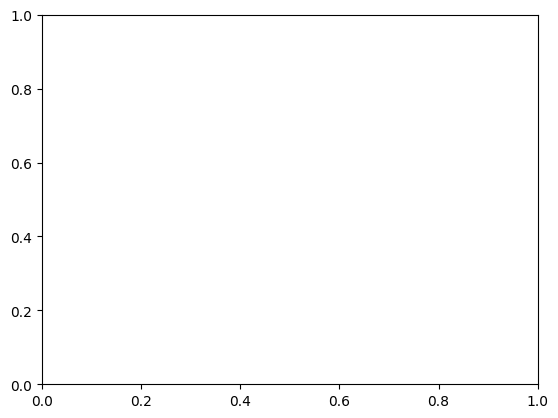

In [250]:
# interesting seeds - 5,8
np.random.seed(5)

node_embeddings_2d_df['labels'] = clustering.labels_

fig, ax = plt.subplots(1, 1)
ax.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1], c=[color_map[label] for label in clustering.labels_])

color_map = {0:'aqua',
             1:'coral',
             2:'green',
             3:'pink',
             4:'goldenrod'}

for label in node_embeddings_2d_df.labels.unique():
    label_embed = node_embeddings_2d_df.query("labels == @label")

    num_to_plot=10

    names_to_plot_index = np.random.choice(len(label_embed.index), size=num_to_plot)
    names_to_plot = label_embed.index[names_to_plot_index]

    for i, name in enumerate(names_to_plot):
        print(label_embed.loc[name])
        ax.annotate(name, (label_embed.loc[name,0].item(), label_embed.loc[name,1].item() ))


In [171]:
subset_msk = (node_embeddings_2d[:,0] < 20) & (node_embeddings_2d[:,1] > 0)
names = embed_32_dim.index.values[subset_msk]